### Import necessary libraries

In [ ]:
# pip install xgboost


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

import matplotlib.pyplot as plt

### Load and Preprocess Data

In [2]:
# Load the dataset
carseats = pd.read_csv('Carseats.csv')
# Convert 'Sales' into a binary classification target variable 'High'
carseats['High'] = carseats['Sales'] > 8
# One-hot encode categorical variables
carseats = pd.get_dummies(carseats, columns=['ShelveLoc', 'Urban', 'US'], drop_first=True)


In [3]:
carseats.head

<bound method NDFrame.head of      Sales  CompPrice  Income  Advertising  Population  Price  Age  Education  \
0     9.50        138      73           11         276    120   42         17   
1    11.22        111      48           16         260     83   65         10   
2    10.06        113      35           10         269     80   59         12   
3     7.40        117     100            4         466     97   55         14   
4     4.15        141      64            3         340    128   38         13   
..     ...        ...     ...          ...         ...    ...  ...        ...   
395  12.57        138     108           17         203    128   33         14   
396   6.14        139      23            3          37    120   55         11   
397   7.41        162      26           12         368    159   40         18   
398   5.94        100      79            7         284     95   50         12   
399   9.71        134      37            0          27    120   49         16  

### Splitting the Dataset

In [4]:
# Define features and labels
X = carseats.drop(['High', 'Sales'], axis=1)
y = carseats['High'].astype(int)


In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Initial XGBoost Model Training

For regression, reg:squarederror
For multiclass classification (predict one outcome from more than two possible classes) XGBoost uses the multi:softprob and multi:softmax objectives.

In [12]:
# Initialize and train the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Hyperparameter Tuning with GridSearchCV
The param_grid is designed for tuning an XGBoost model, specifying a range of values for six key hyperparameters that control its behavior and performance:

**max_depth**: Maximum tree depth for base learners; deeper trees can model more complex patterns but may lead to overfitting.

**min_child_weight**: Minimum sum of instance weight needed in a child; higher values prevent learning very specific patterns, thereby controlling overfitting.

**learning_rate (also known as eta)**: Step size shrinkage used to enhance model robustness by preventing overfitting; smaller values require more boosting rounds but can lead to better generalization.

**n_estimators**: Number of boosting rounds or trees to build; more trees can capture more complex patterns but may also overfit.

**subsample**: Fraction of samples to be used for fitting the individual base learners; prevents overfitting by introducing more randomness into the model.

**colsample_bytree**: Fraction of features (columns) to be used for each tree; similar to subsample, it adds randomness to the model, aiding in preventing overfitting.

In [26]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}
# Initialize GridSearchCV and fit to find the best parameters
grid_search = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=5, verbose=1)
grid_search.fit(X_train_scaled, y_train)
# Print best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Fitting 5 folds for each of 5120 candidates, totalling 25600 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}


In [28]:
# Re-train the model with the best parameters on the full training set
xgb_optimized = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_optimized.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_optimized = xgb_optimized.predict(X_test_scaled)

# Calculate and print the accuracy on the test set
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print("Test set accuracy with optimized parameters: {:.2f}%".format(accuracy_optimized * 100))


Test set accuracy with optimized parameters: 78.33%


### Feature Importance Analysis

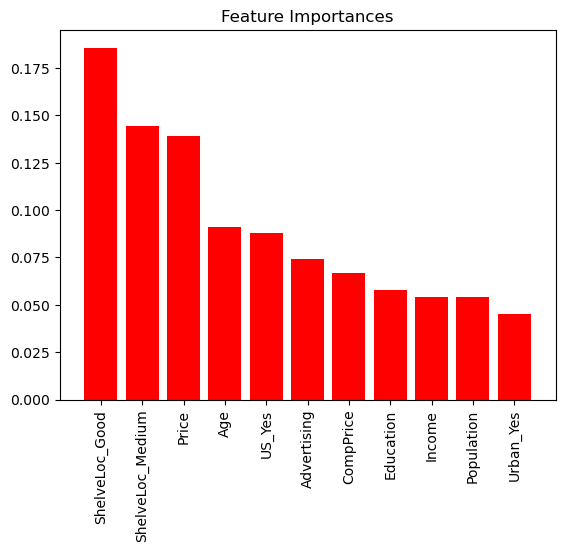

In [29]:
# Get and plot feature importances from the model
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='r', align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


### Model with Selected Features

In [49]:
# Initialize a list to store the average cross-validation scores for different numbers of top features
cv_scores = []

# Iterate over the range of number of features, starting from 1 to the total number of features
for i in range(1, len(indices) + 1):
    # Select the top 'i' features
    top_features = [X_train.columns[indices[j]] for j in range(i)]
    
    # Create the training data using the selected features
    X_train_top = X_train_scaled[:, indices[:i]]
    
    # Initialize the model with the best parameters
    model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    
    # Perform cross-validation and store the mean score
    scores = cross_val_score(model, X_train_top, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the number of features that resulted in the highest mean CV score
optimal_features = np.argmax(cv_scores) + 1  # Adding 1 because list indices start at 0
optimal_score = cv_scores[optimal_features - 1]

print(f"Optimal number of features: {optimal_features}")
print(f"Highest CV accuracy: {optimal_score:.2f}%")



Optimal number of features: 9
Highest CV accuracy: 0.86%


### #plot the CV scores as a function of the number of features

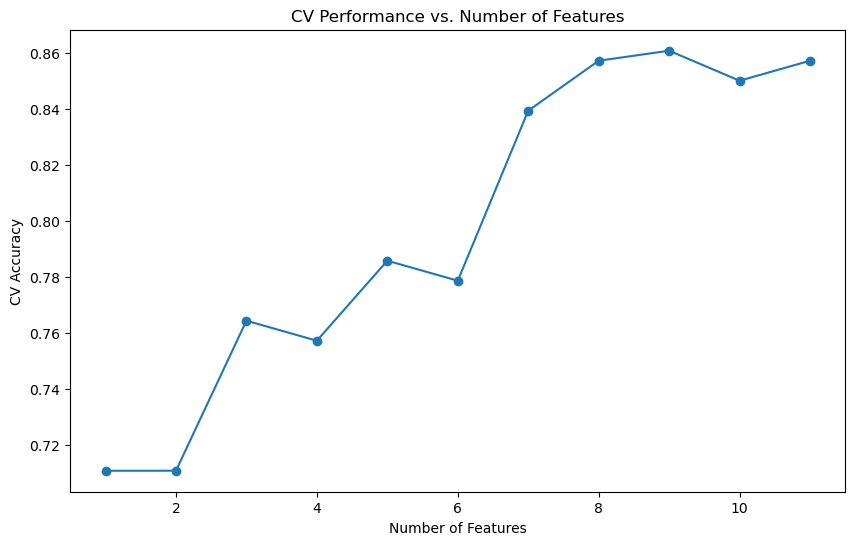

In [50]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(indices) + 1), cv_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('CV Accuracy')
plt.title('CV Performance vs. Number of Features')
plt.show()


In [51]:
# Select the top 'optimal_features' features based on their importance rankings
top_features_indices = indices[:optimal_features]
X_train_optimal = X_train_scaled[:, top_features_indices]
X_test_optimal = X_test_scaled[:, top_features_indices]

# Train the model using the selected subset of features
model_optimal = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
model_optimal.fit(X_train_optimal, y_train)

# Evaluate the model on the test set
y_pred_optimal = model_optimal.predict(X_test_optimal)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)

print(f"Test set accuracy with optimal number of features ({optimal_features}): {accuracy_optimal:.2f}%")


Test set accuracy with optimal number of features (9): 0.81%


### Trying to select features manually

In [52]:
# Train a model using only the top 10 features
top_features = [X_train.columns[i] for i in indices[:10]]
X_train_top = scaler.fit_transform(X_train[top_features])
X_test_top = scaler.transform(X_test[top_features])

In [53]:
# Initialize and train the XGBoost classifier with best parameters and selected features
xgb_top = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_top.fit(X_train_top, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [55]:
# Make predictions and evaluate the model
y_pred_top = xgb_top.predict(X_test_top)
accuracy_top = accuracy_score(y_test, y_pred_top)
print("Accuracy with top 10 features:", accuracy_top)

Accuracy with top 10 features: 0.7833333333333333
